# How MCMC and PyMC Work

## **Markov Chain Monte Carlo (MCMC)**
MCMC is a computational method for approximating complex probability distributions, often used in Bayesian inference to sample from a posterior distribution when direct computation is infeasible. The method constructs a Markov chain that converges to the desired distribution, allowing statistical properties to be estimated from the generated samples.

**Key Concepts in MCMC**:
1. **Markov Chain**: A sequence of random variables where the next state depends only on the current state.
2. **Monte Carlo**: Uses repeated random sampling to approximate results.
3. **Target Distribution**: The probability distribution you want to sample from, often a posterior distribution in Bayesian analysis.
4. **Convergence**: The process by which the Markov chain stabilizes to approximate the target distribution.

**Common MCMC Algorithms**:
- **Metropolis-Hastings**: Proposes new samples and decides their acceptance based on the ratio of the target densities.
- **Gibbs Sampling**: Breaks sampling into smaller parts by iteratively sampling from conditional distributions.
- **Hamiltonian Monte Carlo (HMC)**: Utilizes gradient information to propose efficient updates (used in PyMC).

---

## **PyMC**
[PyMC](https://www.pymc.io/) is a Python library for probabilistic programming that simplifies defining and fitting complex statistical models using MCMC and other Bayesian methods. It provides a high-level framework for model definition, sampling, and inference.

**How PyMC Works**:
1. **Model Definition**:
   - Users define variables as random variables with specified priors and likelihoods.
   - Models can represent complex statistical relationships, such as Bayesian regression or hierarchical models.

2. **Sampling**:
   - PyMC employs state-of-the-art MCMC algorithms, like **NUTS** (No-U-Turn Sampler), a variant of HMC that automatically tunes parameters.
   - Sampling generates draws from the posterior distribution for inference.

3. **Inference and Diagnostics**:
   - PyMC provides tools for analyzing posterior distributions, including trace plots, autocorrelation, and summary statistics.
   - Diagnostics assess convergence and the quality of sampling.

4. **Integration**:
   - PyMC integrates well with visualization tools (e.g., ArviZ for diagnostics) and computational backends like TensorFlow and Theano.

---

## **Why Use PyMC?**
- **Ease of Use**: Intuitive APIs for defining and fitting probabilistic models.
- **Advanced Sampling**: State-of-the-art methods like NUTS ensure efficient sampling.
- **Extensibility**: Supports custom priors, likelihoods, and hierarchical structures.
- **Community Support**: Active ecosystem and resources for learning Bayesian statistics.

PyMC is a powerful tool for Bayesian modeling, abstracting the complexities of MCMC while providing flexibility for advanced users.

---

## Example 1 Coin Flip

Here estimation of the probability of a binomial random process after $N$ trials will be estimated using Bayesian inference. This is a simple example that can be evaluated algebraically. This result will be compared with  the result obtained using pyMC. If $\theta$ is the binomial distribution parameter to be estimated and $Y$ the data to be analyzed then Bayes Theorem is defined by,

$
\begin{align}
P[\theta\, |\, Y] = \frac{P[Y\, | \,\theta] P[\theta]}{P[Y]}
\end{align}
\tag{1}
$

where $P[\theta\, |\, Y]$ is the posterior distribution, $P[Y\, | \,\theta]$ is the likelihood of the parameter estimate given the data, $P[\theta]$ is the prior distribution of the data and $P[Y]$ is the marginal likelihood which is given by,

$
\begin{align}
P[Y] = \int P[Y\, | \,\theta] P[\theta] d\theta = \int P[Y, \theta] d\theta
\end{align}
\tag{2}
$

The likelihood function is the Binomial distribution which is the probability $y$ heads after $N$ tosses,

$
\begin{align}
P[Y\, | \,\theta] = \frac{N!}{y!(N-y)!} \theta^y(1 - \theta)^{N-y}
\end{align}
\tag{3}
$

The prior distribution is the Beta distribution with parameters $\alpha$ and $\beta$ which is useful for modeling random variables with a range of $[0, 1]$,

$
\begin{align}
P[\theta] &= \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) + \Gamma(\beta)} \theta^{\alpha-1}(1- \theta)^{\beta-1} \\
          &= \text{Beta}(\alpha, \beta)
\end{align}
\tag{4}
$

Where $\text{Beta}(\alpha, \beta)$ is the beta function with parameters $\alpha$ and $\beta$.
It is seen that $P[Y\, | \,\theta]$ and $P[\theta]$ have a similar form. It follows that the posterior distribution is given by,

$
\begin{align}
P[\theta\, |\, Y] &\propto \theta^y(1 - \theta)^{N-y} \theta^{\alpha-1}(1- \theta)^{\beta-1} \\
                  &= \text{Beta}(\alpha_{prior} + y, \beta_{prior} + N - y)
\end{align}
\tag{5}
$

In [1]:
%reload_ext autoreload
%autoreload 2

# import system modules and set local import path
import os
import sys
import numpy
from matplotlib import pyplot
from scipy import stats
import pymc
import arviz

sys.path.insert(0, os.path.abspath('../..'))

from lib import config
from lib.plots import (curve, comparison, bar, twinx_bar_line, fcurve_scatter_comparison, positive_negative_bar)

pyplot.style.use(config.glyfish_style)

In [2]:
def simulate_binomial_experiments(theta, N, nexp):
    data = numpy.random.binomial(1, theta, N)
    step = N / nexp
    exp_data = []
    for i in range(nexp):
        exp = data[:int((i + 1) * step)]
        heads = numpy.sum(exp)
        trials = len(exp)
        exp_data.append((heads, trials))
    return exp_data

def compute_posterior(beta_params, data):
    x = numpy.linspace(0, 1, 100)
    posteriors = []
    alpha, beta = beta_params
    for heads, trials in data:
        posterior = stats.beta(alpha + heads, beta + trials - heads).pdf(x)
        posteriors.append(posterior)
    return posteriors

def plot_posteriors(beta_params, data, theta):
    x = numpy.linspace(0, 1, 100)
    posteriors = compute_posterior(beta_params, data)

    title = f"Posterior Distributions\n$\\alpha_{{prior}}$={beta_params[0]}, $\\beta_{{prior}}$={beta_params[1]}, $\\theta$={theta}"
    labels = [f"$n_{{trials}}$={trials}, $n_{{heads}}$={heads}" for heads, trials in data]
    comparison(posteriors, x, ylabel='PDF', xlabel=f"$\\theta$", title=title, labels=labels)


def simulate_binomial(theta, N):
    samples = numpy.random.binomial(1, theta, N)
    heads = len(numpy.where(samples == 1)[0])
    tails = len(numpy.where(samples == 0)[0])
    return samples, heads, tails    

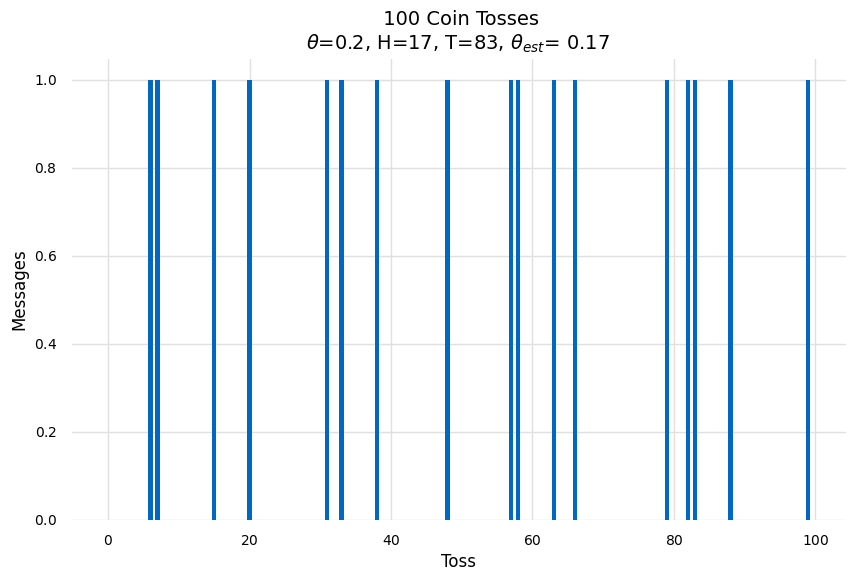

In [3]:
theta = 0.2
ntoss = 100
tau = 50
samples, heads, tails = simulate_binomial(theta, ntoss)

bar(samples, ylabel='Messages', xlabel='Toss', title=f"{ntoss: ,} Coin Tosses\n$\\theta$={theta}, H={heads}, T={tails}, $\\theta_{{est}}$={heads / ntoss: .2f}", alpha=1.0, bar_width=0.6)

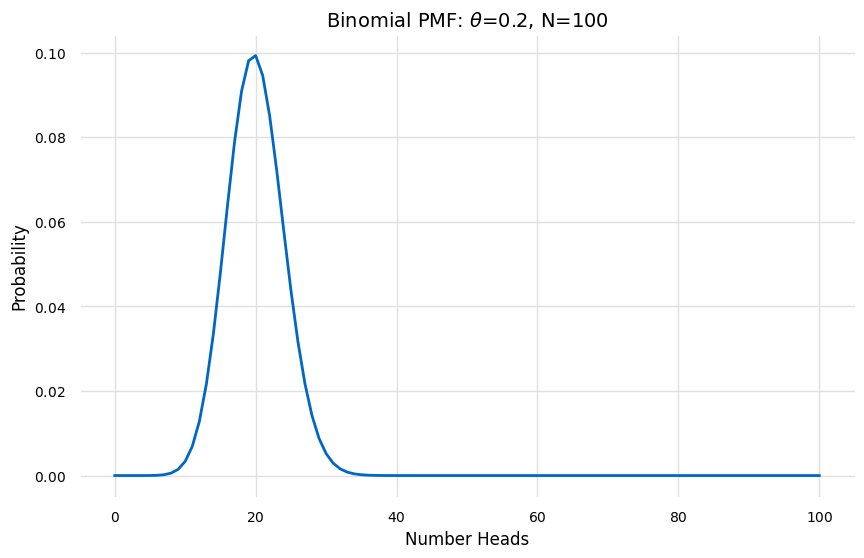

In [4]:
pmf = stats.binom.pmf(numpy.arange(0, ntoss + 1), ntoss, theta)
curve(pmf, ylabel='Probability', xlabel='Number Heads', title=f"Binomial PMF: $\\theta$={theta}, N={ntoss}")

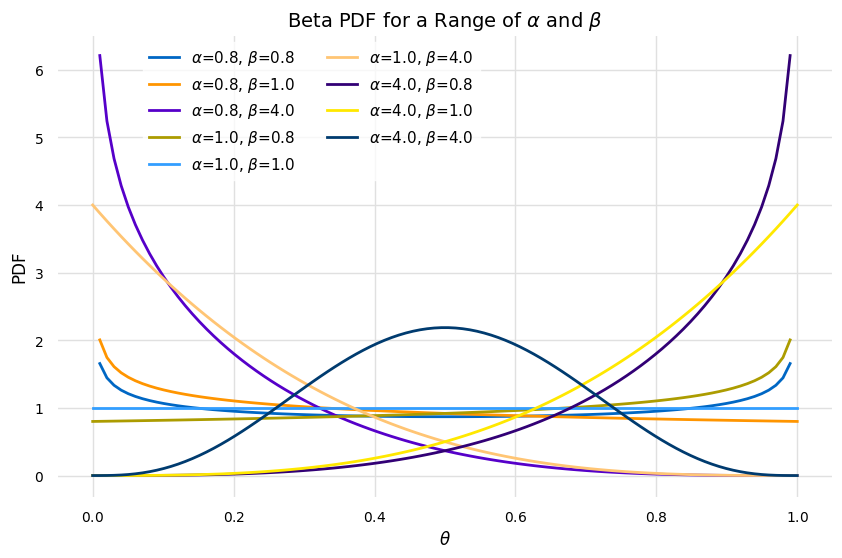

In [5]:

x = numpy.linspace(0, 1, 100)
alpha_vals = [0.8, 0.8, 0.8, 1.0, 1.0, 1.0, 4.0, 4.0, 4.0]
beta_vals = [0.8, 1.0, 4.0, 0.8, 1.0, 4.0, 0.8, 1.0, 4.0]
pdfs = [stats.beta.pdf(x, a, b) for a, b in zip(alpha_vals, beta_vals)]
labels = [f'$\\alpha$={a}, $\\beta$={b}' for a, b in zip(alpha_vals, beta_vals)]
comparison(pdfs, x, ylabel='PDF', xlabel=f"$\\theta$", title=f"Beta PDF for a Range of $\\alpha$ and $\\beta$", labels=labels)

## Examples of Posterior Distributions

Here examples of the posterior beta distribution with somewhat arbitrary parameter values of $\alpha_{prior}$ and $\beta_{prior}$ and data computed from a binomial distribution simulation with a specified value of $\theta$ and number of trails. It is seen that the choice of the prior parameters does not have much impact but the larger values perform a little better.

In [6]:
nexp = 4
beta_params = [(0.8, 1.0), (1.0, 4.0), (4.0, 4.0)]

data = simulate_binomial_experiments(theta, ntoss, nexp)

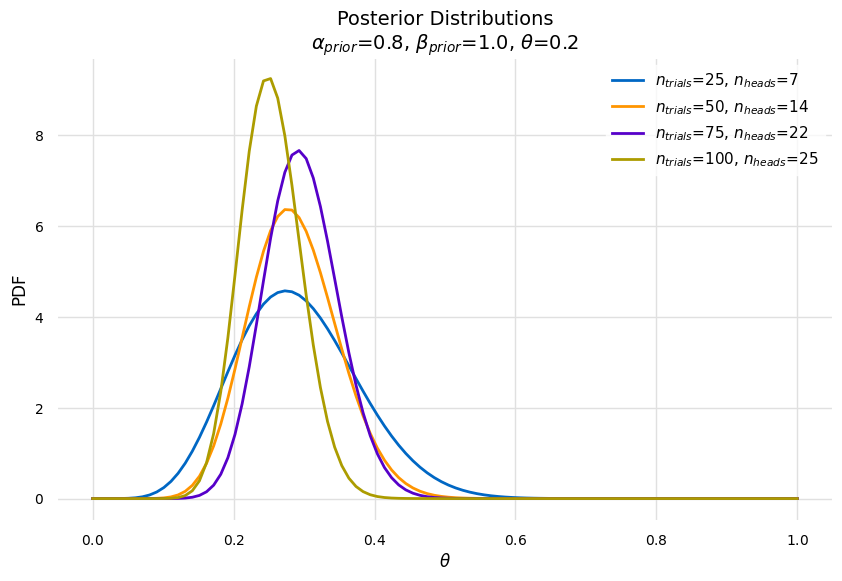

In [7]:
plot_posteriors(beta_params[0], data, theta)

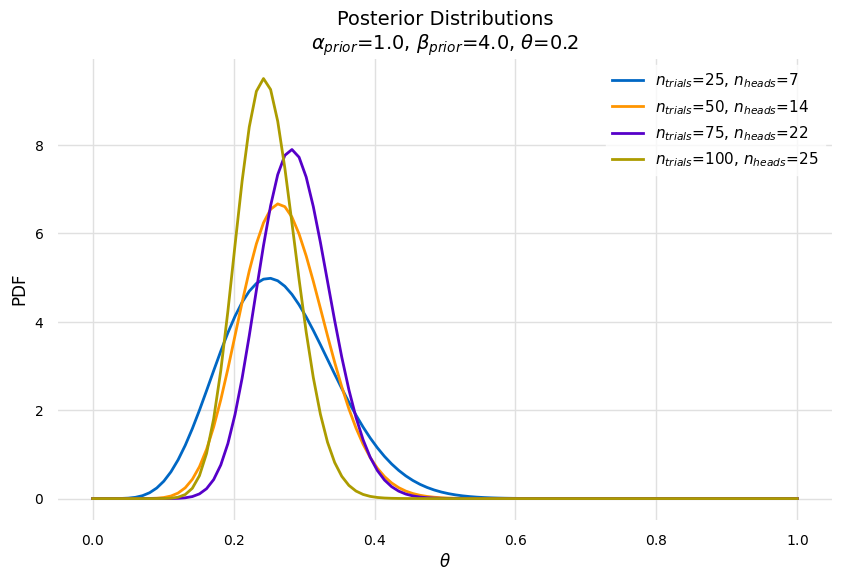

In [8]:
plot_posteriors(beta_params[1], data, theta)

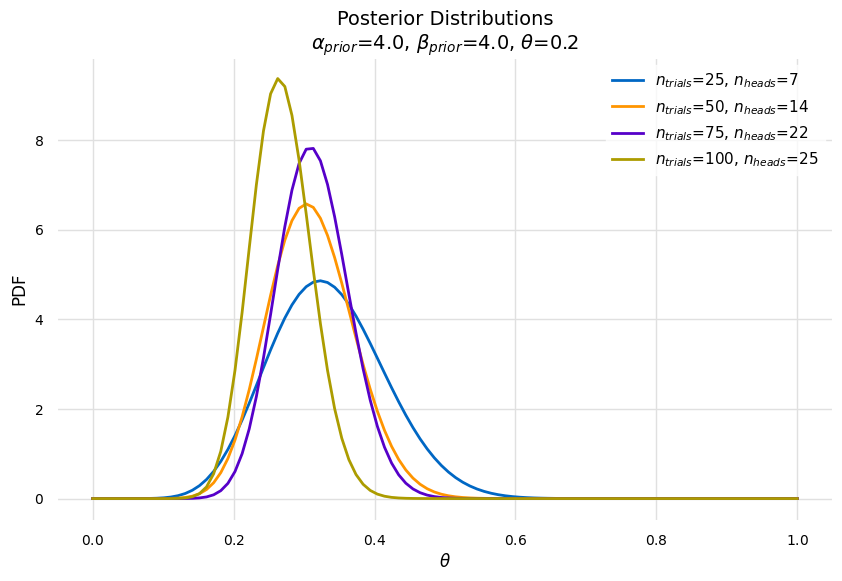

In [9]:
plot_posteriors(beta_params[2], data, theta)

## PyMC Simulation

In [10]:
ntrials = 50
theta_real = 0.35
alpha_prior = 1.0
beta_prior = 1.0
prior_vals = numpy.linspace(0, 1, 100)
nheads = numpy.arange(0, ntrials + 1)

samples, heads, tails = simulate_binomial(theta_real, ntrials)
prior_pdf = stats.beta.pdf(prior_vals, alpha_prior, beta_prior)
likelihood = stats.binom.pmf(nheads, ntrials, theta_real)

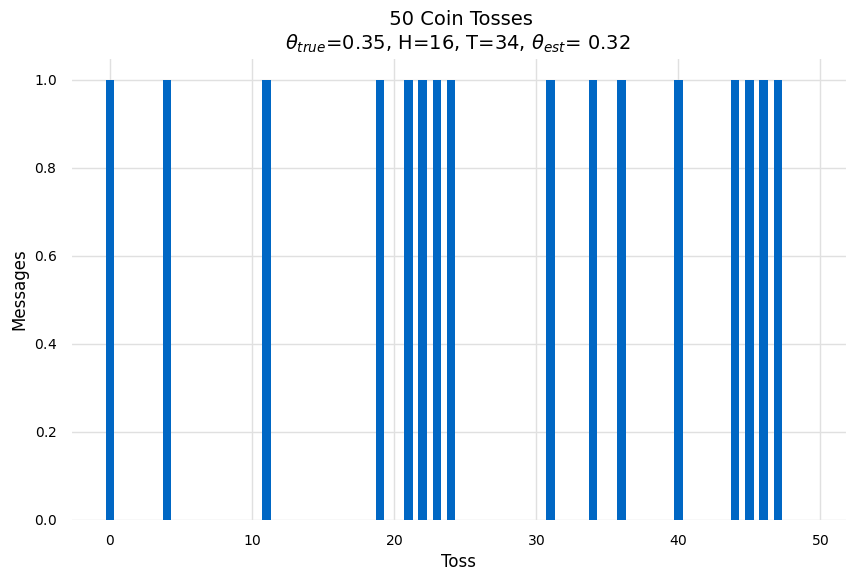

In [15]:
samples, heads, tails = simulate_binomial(theta_real, ntrials)
title = f"{ntrials: ,} Coin Tosses\n$\\theta_{{true}}$={theta_real}, H={heads}, T={tails}, $\\theta_{{est}}$={heads / ntrials: .2f}"

bar(samples, ylabel='Messages', xlabel='Toss', title=title, alpha=1.0, bar_width=0.6)

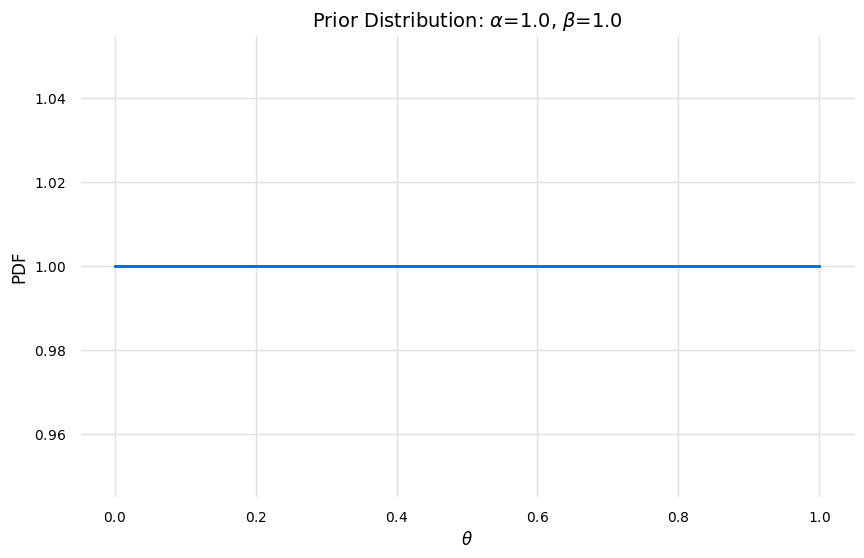

In [16]:
curve(prior_pdf, prior_vals, ylabel='PDF', xlabel='$\\theta$', title=f"Prior Distribution: $\\alpha$={alpha_prior}, $\\beta$={beta_prior}")

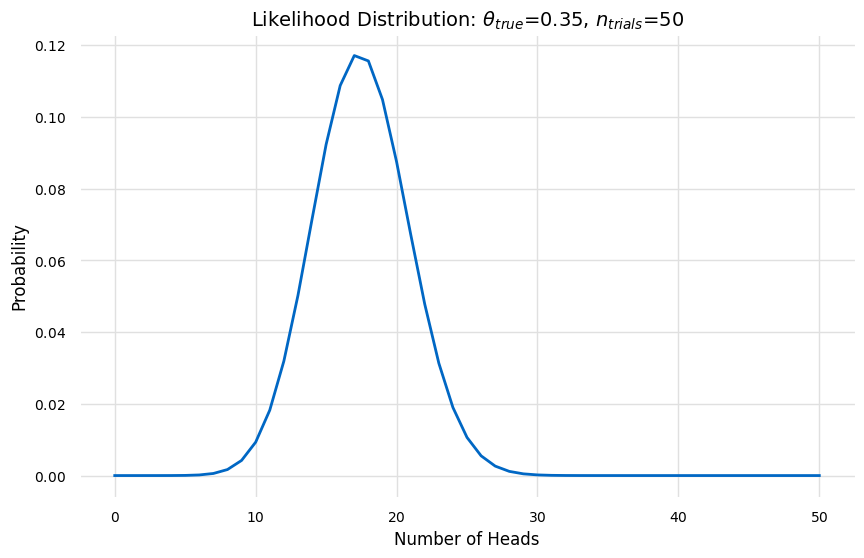

In [17]:
curve(likelihood, nheads, ylabel='Probability', xlabel='Number of Heads', title=f"Likelihood Distribution: $\\theta_{{true}}$={theta_real}, $n_{{trials}}$={ntrials}")

In [18]:
with pymc.Model() as model:
    p = pymc.Beta('θ', alpha=1, beta=1)
    y = pymc.Bernoulli('y', p=p, observed=samples)
    idata = pymc.sample(1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


## Output of `arviz.plot_trace`

The `arviz.plot_trace` function generates **trace plots** for the posterior distributions of the parameters in a Bayesian model. A trace plot is a combination of two key visualizations:

1. **Trace Plot**:
   - A time series of sampled values for each parameter across iterations of the MCMC process.
   - It helps assess how well the Markov chain has explored the parameter space.
   - A well-mixed and stationary trace (no trends, consistent variability) indicates good sampling and convergence.

2. **Posterior Distribution Plot**:
   - A kernel density estimate (KDE) or histogram of the sampled values for the parameter.
   - Provides a summary of the posterior distribution for each parameter.

---

#### **Key Features of `arviz.plot_trace`**

1. **Parameter Rows**:
   - Each row corresponds to a parameter or variable in the model.
   - Includes both the trace plot and the posterior distribution for that parameter.

2. **Multiple Chains**:
   - If multiple MCMC chains are used, each chain's trace is plotted in a different color.
   - This helps assess chain convergence and mixing.

3. **Stationarity and Mixing**:
   - A well-converged trace should appear stationary, without trends or drifts.
   - Chains should overlap and mix well, indicating efficient exploration of the posterior.

4. **Density Representation**:
   - The posterior distribution on the right shows the central tendency and spread of the parameter estimates.
   - Multiple peaks in the density could indicate convergence issues or multimodal distributions.

---

#### **How to Interpret the Trace Plot**
- **Trace Plots**:
  - Look for **stationarity**: The chains should oscillate around a consistent mean without trends or drifts.
  - Assess **mixing**: Overlapping chains indicate good mixing.
  - Identify anomalies, such as abrupt jumps, trends, or long flat regions, which may suggest poor sampling or convergence issues.

- **Posterior Distribution**:
  - Examine the shape of the distribution: A unimodal, smooth distribution is desirable.
  - Use the posterior to identify the central tendency (mean, median) and spread (credible intervals) for each parameter.

---

#### **Example Trace Plot**
For a parameter like `alpha`:

- **Trace Plot (Left)**:
  - A time series showing sampled values for `alpha` from each MCMC chain.
  - Should exhibit stationary behavior with no trends.

- **Posterior Distribution (Right)**:
  - A KDE plot summarizing the posterior distribution of `alpha`, showing the mean and variability.

---

#### **Common Use Cases**
- **Diagnose Convergence**:
  - Identify whether chains have reached stationarity and mixed well.
- **Assess Sampling Quality**:
  - Poor mixing or trends in the trace suggest the need for more samples or better tuning.
- **Summarize Posterior**:
  - The posterior distribution plot helps infer the parameter's central tendency and credible intervals.

By combining these visualizations, `arviz.plot_trace` provides a powerful diagnostic tool for evaluating the results of Bayesian MCMC sampling.

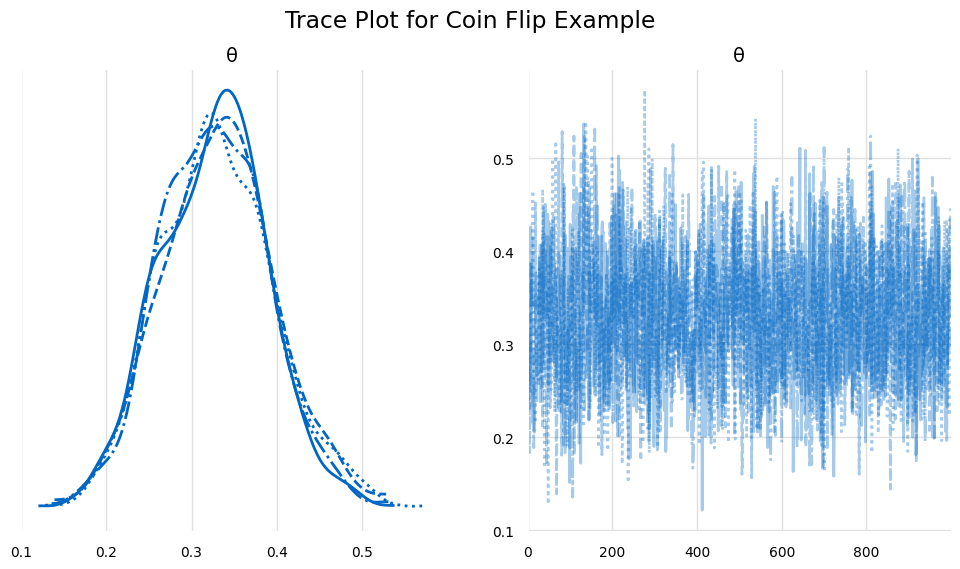

In [19]:
arviz.plot_trace(idata, figsize=(12, 6))
_ = pyplot.suptitle('Trace Plot for Coin Flip Example')

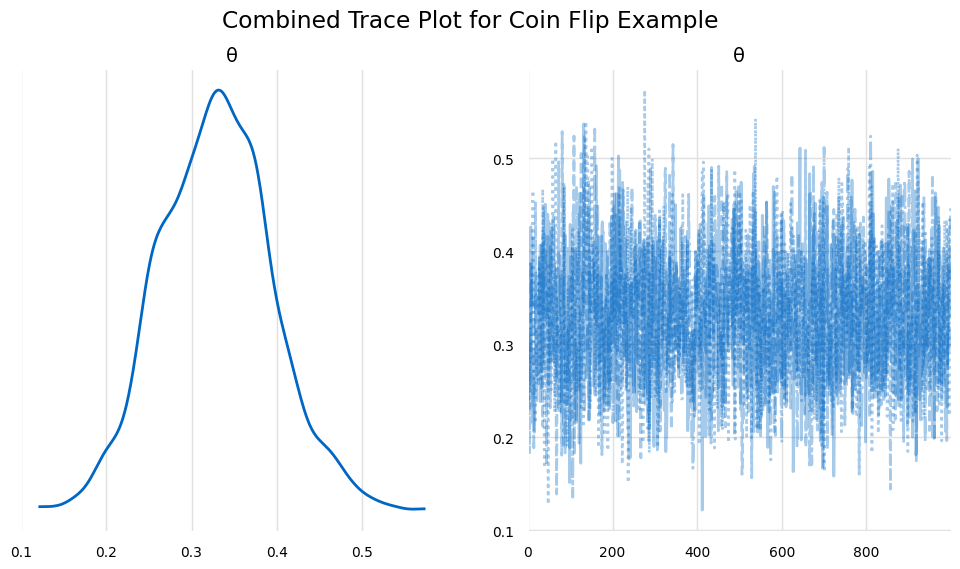

In [20]:
arviz.plot_trace(idata, figsize=(12, 6), combined=True)
_ = pyplot.suptitle('Combined Trace Plot for Coin Flip Example')

In [21]:
idata.posterior['θ'].values

array([[0.23404045, 0.35254562, 0.37059285, ..., 0.38367857, 0.35276108,
        0.32915846],
       [0.30993158, 0.31785097, 0.239172  , ..., 0.43382554, 0.33920865,
        0.35059457],
       [0.3056302 , 0.26391543, 0.28351821, ..., 0.29795556, 0.31115567,
        0.31115567],
       [0.30647572, 0.25134794, 0.24512377, ..., 0.37133802, 0.39780676,
        0.4507945 ]])

## Rank Bars Plot (`arviz.plot_trace()`)

In the **rank bars** plot within `arviz.plot_trace()`, the **y-axis** represents the **frequency or proportion of ranks** within the chain for the given parameter.

#### **Y-Axis Interpretation**
- The rank bars divide the sampled values into bins (rank groups) based on their relative order (rank) across all samples.
- The **y-axis values** indicate how often samples from a specific Markov Chain Monte Carlo (MCMC) chain fall into a given rank bin.
- If the ranks are uniformly distributed across bins (and chains), the heights of the bars on the y-axis will be approximately equal.

#### **Key Points**
1. **Uniform Distribution**: 
   - If the model has converged and chains are mixing well, the bars will have roughly the same height, meaning each rank bin is equally populated.

2. **Non-Uniform Distribution**:
   - Skewed or uneven heights suggest convergence or mixing issues. For example:
     - A chain stuck in one part of the parameter space may overpopulate certain rank bins.
     - Poor mixing could result in some chains dominating certain ranks while avoiding others.

#### **Example**
- **Y-axis scale (relative frequencies)**: 
  - Suppose you have 100 samples per chain and the ranks are divided into 10 bins. If mixing is perfect, each rank bin will have about 10% (0.1) of the samples for each chain, and the bars on the y-axis will have a height of 0.1.

- **Issues with mixing or convergence**:
  - If one chain gets "stuck," it might have more than 10% in one bin and less than 10% in others.

This y-axis behavior is crucial for visually assessing the quality of the sampling process.

In [ ]:
arviz.plot_trace(idata, kind='rank_bars', combined=True, figsize=(12, 6))
_ = pyplot.suptitle('Rank Bars Plot for Coin Flip Example') 

### Output of `arviz.summary`

The `arviz.summary` function generates a tabular summary of the posterior distribution of parameters from a Bayesian model. This summary provides key statistical metrics to interpret the results of an MCMC sampling process. Below is an explanation of the main components typically included in the output:

#### **Columns in `arviz.summary`**

1. **mean**:
   - The posterior mean (average) of the samples for each parameter.
   - Represents the central tendency of the parameter's posterior distribution.

2. **sd**:
   - The standard deviation of the posterior samples for each parameter.
   - Quantifies the uncertainty or variability in the parameter estimates.

3. **hdi_3%** and **hdi_97%** (or other HDI bounds):
   - The bounds of the 94% (default) *Highest Density Interval* (HDI).
   - The HDI (High Density Interval) is an interval within which the true parameter value lies with the specified probability (e.g., 94%), representing the range of most credible values.

4. **mcse_mean**:
   - Monte Carlo Standard Error (MCSE) for the mean.
   - Indicates the uncertainty in the mean estimate due to finite sampling.

5. **mcse_sd**:
   - MCSE for the standard deviation.
   - Represents the uncertainty in the standard deviation estimate due to finite sampling.

6. **ess_bulk**:
   - Effective Sample Size (bulk).
   - Measures the effective number of independent samples for the bulk of the distribution.
   - A high ESS indicates good sampling efficiency and low autocorrelation.

7. **ess_tail**:
   - Effective Sample Size (tail).
   - Focuses on the tail of the distribution and assesses the number of effective independent samples there.

8. **r_hat**:
   - The Gelman-Rubin convergence diagnostic (R-hat).
   - Values close to 1 indicate good convergence of the MCMC chains. Values significantly above 1 suggest the chains have not mixed well and may need more iterations.

---

#### **Interpreting the Output**
- **Central Tendency (Mean)**: Use the `mean` to interpret the "average" value of the parameter.
- **Uncertainty (SD and HDI)**: The `sd` and `hdi_x%` provide a sense of the variability and credible intervals for the parameter estimates.
- **Convergence (R-hat)**: Check that `r_hat` is close to 1 for all parameters to ensure the MCMC chains have converged.
- **Sampling Efficiency (ESS)**: Ensure that `ess_bulk` and `ess_tail` are sufficiently large for reliable inference.

---

#### **Example Table**
| Parameter  | mean  | sd   | hdi_3% | hdi_97% | mcse_mean | mcse_sd | ess_bulk | ess_tail | r_hat |
|------------|-------|------|--------|---------|-----------|---------|----------|----------|-------|
| alpha      | 1.23  | 0.12 | 1.01   | 1.45    | 0.01      | 0.002   | 1000     | 950      | 1.00  |
| beta       | -0.45 | 0.09 | -0.62  | -0.28   | 0.01      | 0.001   | 950      | 930      | 1.01  |

This table shows the posterior mean, variability, credible intervals, and diagnostics for two parameters, `alpha` and `beta`.

---

#### **Use in Practice**
The `arviz.summary` output helps assess the quality of the MCMC sampling (via diagnostics like `ess` and `r_hat`) and provides an intuitive summary of the posterior distributions for interpreting model results.

In [22]:
arviz.summary(idata).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,0.33,0.06,0.21,0.45,0.0,0.0,1577.0,2745.0,1.0


## `arviz.plot_posterior`

The `arviz.plot_posterior` function generates posterior distribution plots for parameters in a Bayesian model. It visualizes the probability distributions of the parameters obtained from the posterior samples, helping to understand their central tendencies, spread, and credible intervals.

---

### **Key Features of `arviz.plot_posterior`**

1. **Posterior Density Plot**:
   - Displays the posterior distribution as a smoothed density curve (Kernel Density Estimate, KDE) or a histogram.
   - Provides a visual summary of the parameter's uncertainty and likely values.

2. **Summary Statistics**:
   - By default, the plot shows the mean or median of the distribution as a vertical line.
   - Includes the Highest Density Interval (HDI) to highlight the range of most credible values, often the 94% HDI (can be adjusted).

3. **Credible Intervals (HDI)**:
   - Highlights the range where the parameter lies with a given probability (e.g., 94% by default).
   - Useful for understanding the range of plausible values for the parameter.

4. **Optional Rug Plot**:
   - Adds tick marks (a "rug") along the x-axis to indicate individual sampled values, giving a sense of the raw data distribution.

5. **Multiple Dimensions**:
   - Can display separate plots for each parameter in a multi-parameter model.

---

### **Customization Options**
- **`credible_interval`**: Adjusts the width of the HDI (e.g., 90%, 95%).
- **`hdi_prob`**: Specifies the range of the HDI to display.
- **`kind`**: Choose between `kde` (smoothed density) or `hist` (histogram).
- **`point_estimate`**: Specify whether to show the mean or median as a point estimate.
- **`ref_val`**: Add a reference line to compare the posterior distribution against a specific value (e.g., zero or a threshold).
- **`rope`**: Display a Region of Practical Equivalence (ROPE) for comparing the posterior distribution to a practical threshold.

---

### **How to Interpret the Plot**
1. **Shape of the Distribution**:
   - A unimodal, smooth distribution indicates a single dominant region in the posterior.
   - A multimodal distribution suggests multiple plausible parameter regions.

2. **Point Estimate**:
   - The mean or median gives a central value for the parameter estimate.

3. **High Density Interval (HDI)**:
   - Indicates the range within which the parameter is likely to lie with a specified probability (e.g., 94%).
   - Narrower intervals suggest higher certainty about the parameter estimate.

4. **Comparison to Reference Values**:
   - If a `ref_val` is provided, observe how much of the posterior distribution lies above or below this value.

5. **ROPE (Optional)**:
   - Assess whether the posterior falls entirely or partially within a region of practical equivalence, indicating practical significance.

---

### **Example Use Cases**
- **Parameter Estimation**:
  - Understand the range of plausible values and central tendency for parameters.
- **Hypothesis Testing**:
  - Compare the posterior against a null or reference value (e.g., `ref_val`).
- **Assess Uncertainty**:
  - Visualize the uncertainty in parameter estimates using HDIs.

`arviz.plot_posterior` provides an intuitive way to summarize and interpret Bayesian posterior distributions, making it a key tool for Bayesian inference.

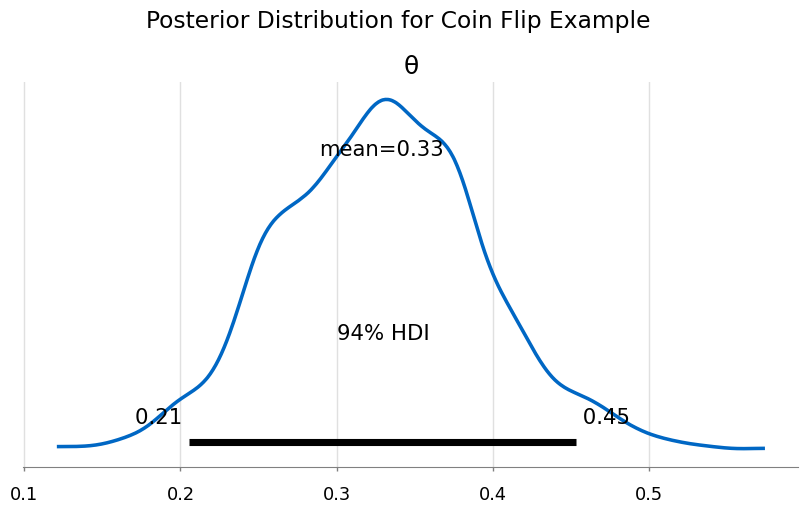

In [23]:
arviz.plot_posterior(idata, figsize=(10, 5))
_ = pyplot.suptitle('Posterior Distribution for Coin Flip Example', y=1.025)

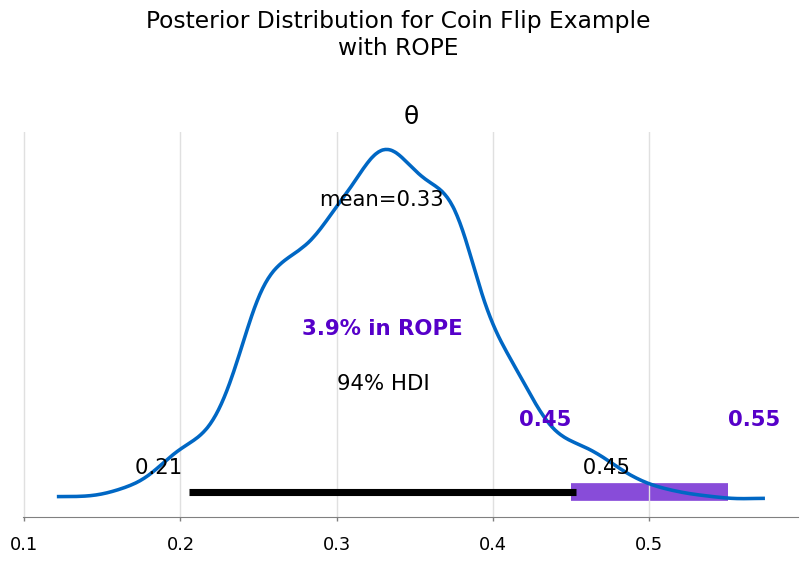

In [24]:
arviz.plot_posterior(idata, figsize=(10, 5), rope=[0.45, 0.55])
_ = pyplot.suptitle('Posterior Distribution for Coin Flip Example\nwith ROPE', y=1.125) 

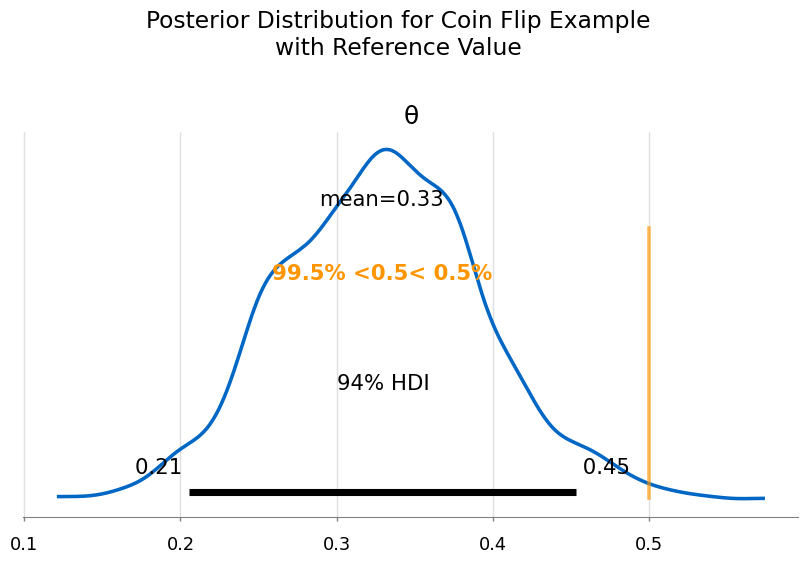

In [25]:
arviz.plot_posterior(idata, figsize=(10, 5), ref_val=0.5)
_ = pyplot.suptitle('Posterior Distribution for Coin Flip Example\nwith Reference Value', y=1.125)

### `arviz.plot_bf`

The `arviz.plot_bf` function in ArviZ estimates and visualizes the **Bayes Factor (BF)** for comparing two nested models in Bayesian analysis. It assesses the evidence provided by the data in favor of one model (alternative hypothesis, \( H_1 \)) over another (null hypothesis, \( H_0 \)), where \( H_0 \) is a special case of \( H_1 \). This function is particularly useful for hypothesis testing involving point-null hypotheses.

---

#### **Key Features of `arviz.plot_bf`**

1. **Bayes Factor Estimation**:
   - Estimates the Bayes Factor using the **Savage-Dickey density ratio** method, which is applicable when comparing nested models with a point-null hypothesis. [oai_citation_attribution:1‡ArviZ](https://python.arviz.org/en/stable/api/generated/arviz.plot_bf.html?utm_source=chatgpt.com)

2. **Visualization**:
   - Plots the prior and posterior distributions of the parameter of interest, highlighting the density at the reference value (e.g., zero) to illustrate the calculation of the Bayes Factor.

3. **Customization**:
   - Allows specification of the parameter to test, the reference value for the null hypothesis, custom prior distributions, and plot aesthetics such as colors and figure size.

---
### **Savage-Dickey Density Ratio**

The **Savage-Dickey Density Ratio** is a method for computing the **Bayes Factor (BF)** to compare a point-null hypothesis ($H_0$) against an alternative hypothesis ($H_1$) in Bayesian inference. It leverages the relationship between prior and posterior distributions, providing an efficient way to compute the Bayes Factor for nested models where $H_0$ is a special case of $H_1$.

### **Definition**

The Savage-Dickey Density Ratio is defined as:

$
\begin{align}
BF_{10} = \frac{P(\theta = \theta_0 \mid \text{data})}{P(\theta = \theta_0)}
\end{align}
$

Where:
- $P(\theta = \theta_0 \mid \text{data})$: The posterior density at the null value $\theta_0$.
- $P(\theta = \theta_0)$: The prior density at the null value $\theta_0$.


### **Key Idea**

The Bayes Factor is computed by comparing the relative densities of the prior and posterior distributions at the specific point representing the null hypothesis. Since the posterior is proportional to the product of the prior and the likelihood, this approach avoids integrating over the full parameter space, simplifying the calculation.


## **When to Use It**

The Savage-Dickey Density Ratio is appropriate when:
1. **Nested Models**: The null hypothesis ($H_0$) is a special case of the alternative hypothesis ($H_1$).
   - Example: Testing whether a parameter $\theta = 0$ ($H_0$) versus $\theta \neq 0$ ($H_1$).
2. **Point-Null Hypothesis**: The null hypothesis is a specific point value (e.g., $\theta = 0$).
3. **Well-Defined Prior**: The prior distribution is continuous and well-defined at the null value.

### **Advantages**

1. **Efficiency**: Avoids integrating over the full parameter space, making it computationally efficient.
2. **Simplicity**: Requires only the prior and posterior densities at the null value.
3. **Flexibility**: Can be applied with any prior and posterior distribution as long as densities at the null are defined.

### **Interpretation**

- A large $BF_{10}$ indicates strong evidence in favor of the alternative hypothesis ($H_1$).
- A small $BF_{10}$ (or a large $BF_{01}$) indicates strong evidence in favor of the null hypothesis ($H_0$).

For example:
- If $BF_{10} = 3$, the data are three times more likely under $H_1$ than under $H_0$.
- If $BF_{10} = 0.5$ (or equivalently $BF_{01} = 2$), the data are twice as likely under $H_0$ than under $H_1$.

### **Limitations**

1. **Point Nulls Only**: This method applies only to point-null hypotheses and cannot be used for interval-null or other complex hypotheses.
2. **Prior Sensitivity**: The result is sensitive to the choice of the prior, especially the prior density at the null value.

### **Example**

Suppose we are testing whether a regression coefficient $\beta = 0$ (null hypothesis) versus $\beta \neq 0$ (alternative hypothesis). Using the Savage-Dickey Density Ratio:
1. Compute the prior density $P(\beta = 0)$ at $\beta = 0$.
2. Compute the posterior density $P(\beta = 0 \mid \text{data})$ at $\beta = 0$.
3. Calculate the Bayes Factor as:

$
\begin{align}
BF_{10} = \frac{P(\beta = 0 \mid \text{data})}{P(\beta = 0)}
\end{align}
$

The **Savage-Dickey Density Ratio** is a powerful tool for Bayesian hypothesis testing, offering an efficient way to compute Bayes Factors for point-null hypotheses in nested models.

---

#### `arviz.plot_bf` **Parameters**

- **`idata`**: InferenceData object containing the posterior samples and optionally prior samples.

- **`var_name`**: String specifying the name of the variable to test.

- **`prior`**: Optional array specifying a custom prior distribution for sensitivity analysis. If not provided, the prior from `idata` is used.

- **`ref_val`**: Numeric value representing the point-null hypothesis (default is 0).

- **`colors`**: Tuple specifying colors for the prior and posterior distributions (default is `('C0', 'C1')`).

- **`figsize`**: Tuple specifying the figure size. If `None`, it is defined automatically.

- **`textsize`**: Float for scaling text size of labels and titles. If `None`, it is auto-scaled based on `figsize`.

- **`plot_kwargs`**: Dictionary of additional keyword arguments passed to the plotting function.

- **`hist_kwargs`**: Dictionary of additional keyword arguments passed to the histogram function (for discrete variables).

- **`ax`**: Matplotlib axes object to plot on. If `None`, a new figure and axes are created.

- **`backend`**: String specifying the plotting backend (`'matplotlib'` or `'bokeh'`; default is `'matplotlib'`).

- **`backend_kwargs`**: Dictionary of backend-specific keyword arguments.

- **`show`**: Boolean to display the plot immediately (default is `None`).

---

#### **Returns**

- **`dict`**: A dictionary containing:
  - **`BF10`**: Bayes Factor in favor of \( H_1 \) over \( H_0 \).
  - **`BF01`**: Bayes Factor in favor of \( H_0 \) over \( H_1 \).

- **`axes`**: Matplotlib Axes or Bokeh Figure object containing the plot.


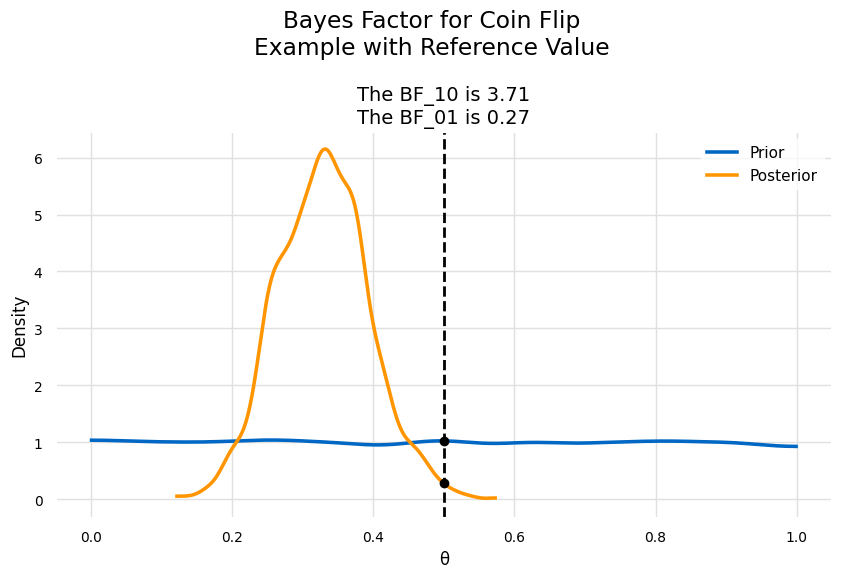

In [26]:
arviz.plot_bf(idata, var_name='θ', figsize=(10, 5), prior=numpy.random.uniform(0, 1, 10000), ref_val=0.5)
_ = pyplot.suptitle('Bayes Factor for Coin Flip\nExample with Reference Value', y=1.125)

## Loss Functions

### Loss Functions in Bayesian Analysis

In Bayesian analysis, **loss functions** quantify the cost or penalty associated with making incorrect decisions or predictions based on uncertain data. They are a cornerstone of **decision theory**, translating probabilistic results into actionable decisions by minimizing expected losses.

---

#### **Key Concepts**

1. **Posterior Distribution**:
   - The posterior distribution represents the probability of model parameters or outcomes given the observed data.
   - Loss functions are applied to the posterior to derive optimal decisions, estimates, or predictions.

2. **Decision Rule**:
   - A decision rule maps the posterior distribution to a specific action or estimate by minimizing the expected loss.
   - The optimal decision depends on the choice of the loss function.

3. **Expected Loss**:
   - The expected loss is the average penalty across all possible outcomes, weighted by their posterior probabilities.
   - Formally:
     $
     \begin{align}
     \text{Expected Loss} = \int L(\theta, a) \, p(\theta \mid \text{data}) \, d\theta
     \end{align}
     $
     Where:
     - \(L(\theta, a)\): The loss function measuring the penalty for choosing action \(a\) when the true parameter is \(\theta\).
     - \(p(\theta \mid \text{data})\): The posterior distribution of \(\theta\).

4. **Action**:
   - The "action" can be a prediction, an estimate of a parameter, or any decision based on the analysis.

---

#### **Common Loss Functions**

1. **Squared Error Loss**:
   - Penalizes the squared difference between the true value (\(\theta\)) and the estimate (\(a\)).
   - Commonly used in regression and estimation problems.
   - **Optimal decision**: The posterior **mean**.
   - Formula:
     $
     \begin{align}
     L(\theta, a) = (\theta - a)^2
     \end{align}
     $

2. **Absolute Error Loss**:
   - Penalizes the absolute difference between the true value and the estimate.
   - **Optimal decision**: The posterior **median**.
   - Formula:
     $
     \begin{align}
     L(\theta, a) = |\theta - a|
     \end{align}
     $

3. **Zero-One Loss**:
   - Assigns a fixed penalty for making an incorrect decision, regardless of the degree of error.
   - Common in classification problems.
   - **Optimal decision**: The posterior **mode**.
   - Formula:
     $
     \begin{align}
     L(\theta, a) =
     \begin{cases} 
     0 & \text{if } \theta = a \\
     1 & \text{otherwise}
     \end{cases}
     \end{align}
     $

4. **Custom Loss Functions**:
   - Tailored to specific decision-making contexts where the cost of different types of errors varies.
   - For example, in medical diagnostics, the loss for a false negative may be much higher than for a false positive.

---

#### **Applications of Loss Functions in Bayesian Analysis**

1. **Parameter Estimation**:
   - Use the posterior distribution to select an estimate (e.g., mean, median, or mode) based on the chosen loss function.

2. **Prediction**:
   - Generate optimal predictions that balance uncertainty and the costs of potential errors.

3. **Model Selection**:
   - Compare models by incorporating both their fit to the data and the cost of decisions implied by their predictions.

4. **Decision-Making Under Uncertainty**:
   - Make choices (e.g., treatment plans, financial investments) that minimize expected loss, accounting for the risks and benefits of each action.

---

#### **Key Takeaways**

- Loss functions bridge the gap between probabilistic Bayesian inference and practical decision-making.
- The choice of a loss function depends on the context and the costs associated with different types of errors.
- By minimizing expected loss, Bayesian analysis provides a principled framework for making optimal decisions under uncertainty.

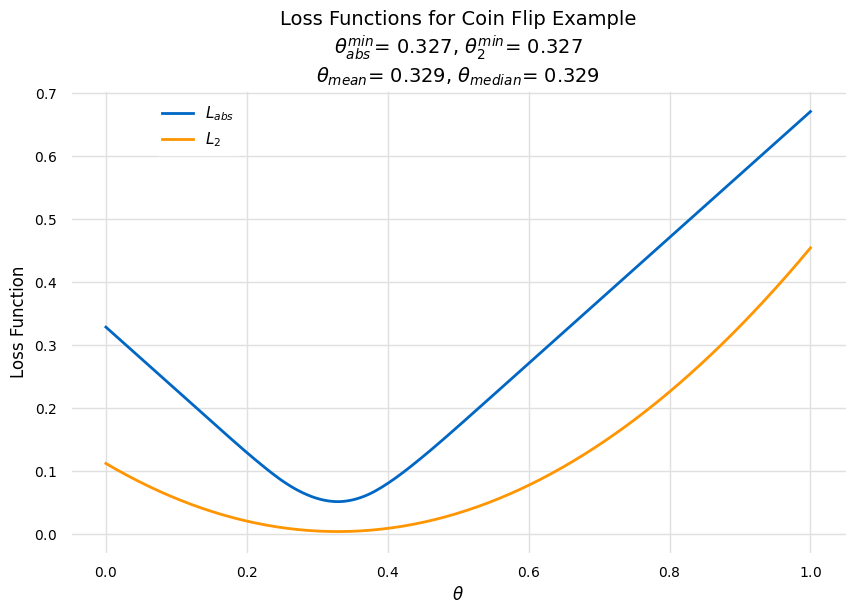

In [34]:
grid = numpy.linspace(0, 1, 200)
θ_pos = idata.posterior['θ'] 
loss_abs = numpy.array([numpy.mean(abs(i - θ_pos)) for i in grid])
loss_2 = numpy.array([numpy.mean((i - θ_pos)**2) for i in grid])

min_abs = numpy.argmin(loss_abs)
min_2 = numpy.argmin(loss_2)

mean_θ = numpy.mean(θ_pos)
median_θ = numpy.median(θ_pos)

title = f"Loss Functions for Coin Flip Example\n$\\theta_{{abs}}^{{min}}$={grid[min_abs]: .3f}, $\\theta_2^{{min}}$={grid[min_2]: .3f}" \
        f"\n$\\theta_{{mean}}$={mean_θ: .3f}, $\\theta_{{median}}$={median_θ: .3f}"
comparison([loss_abs, loss_2], grid, ylabel='Loss Function', xlabel='$\\theta$', title=title, labels=['$L_{abs}$', '$L_2$'])    